[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JinmiaoChenLab/DISCOtoolkit_py/blob/main/docs/CELLiD_celltype_annotation.ipynb)
# Cell Type Annotation using CELLiD

In this tutorial, we will provide a quick guideline for conducting cell type annotation using discotoolkit. The following steps outline the process:

1. Visit the discotoolkit website to find a sample or cell type of interest.
2. Utilize the `dt.filter_disco_metadata` function to filter the relevant data from the database.
3. Employ the `dt.download_disco_data` function to download the data in the `h5ad` extension based on the filtered sample.
4. Apply preprocessing to the counts matrix and obtain normalized gene expression, which will serve as the input for the `dt.CELLiD_cluster` function.

In [1]:
# for google colab
# pip install discotoolkit
# import package
import os
import re

import discotoolkit as dt
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# adding ignore warning to clean the code
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [12]:
# setting params for the visualisation
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

# Set the plotting backend to 'umap-learn' for interactive plot
sc.settings.plotting_backend = 'umap-learn'

To maintain simplicity, we exclusively employ sample metadata as the filtering criterion to extract a single sample from the `bone_marrow tissue` category. Subsequently, we proceed to download the pertinent data following the guidelines elucidated in the download data tutorial.

In [3]:
# filter to only one sample
filter = dt.Filter(sample_id="GSM6709896")

# filter the database based on the metadata
metadata = dt.filter_disco_metadata(filter) 

# download the data and ignore if it is exist
dt.download_disco_data(metadata) 

INFO:root:Filtering sample
INFO:root:1 samples and 887 cells were found
100%|██████████| 1.97M/1.97M [00:00<00:00, 26.8MB/s]
... storing 'cell_type' as categorical
... storing 'sample_id' as categorical
... storing 'project_id' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


We also provide a helper function that enables users to access and view the strings associated with the atlases

In [4]:
# helper function to allow the user to see how many atlases are in disco database
print(dt.get_atlas())

INFO:root:Downloading reference dataset...


['placenta', 'bone_marrow', 'fibroblast', 'HIV_blood', 'COVID-19_blood', 'Crohns_disease_ileum', 'type_2_diabetes_pancreas', 'pancreas_cell', 'dengue_blood', 'type_1_diabetes_pancreas', 'blood', 'liver_nucleus', 'gingiva', 'skeletal_muscle', 'skin', 'kidney', 'thymus', 'lung', 'adipose_cell', 'stomach', 'basophil_mast_cell', 'ovary', 'testis', 'heart', 'brain', 'bladder', 'intestine', 'liver_cell', 'adipose_nucleus', 'HNSCC_blood', 'PDAC_pancreas', 'HIV_cerebrospinal_fluid', 'tonsil', 'adrenal_gland', 'breast', 'breast_milk', 'eye', 'sarcoidosis_blood', 'AD_frontal_cortex_parenchyma']


The downloaded data is in h5ad format, and we need to import `scanpy` to read the data.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    The input data for the cell type annotation function needs to be normalized and in non-log space. In the example below, the downloaded gene expression represents a count matrix, so we only need to normalize the data using `sc.pp.normalize_total`. If the data is in log space, please exponentiate it to convert it into non-log space.
  </p>
</div>

The required format for the input data is (gene, cluster).

In [6]:
# first we need to read the h5ad file and extract the raw gene expression
adata = sc.read_h5ad("DISCOtmp/GSM6709896.h5ad")

# typical analysis pipeline in scanpy
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

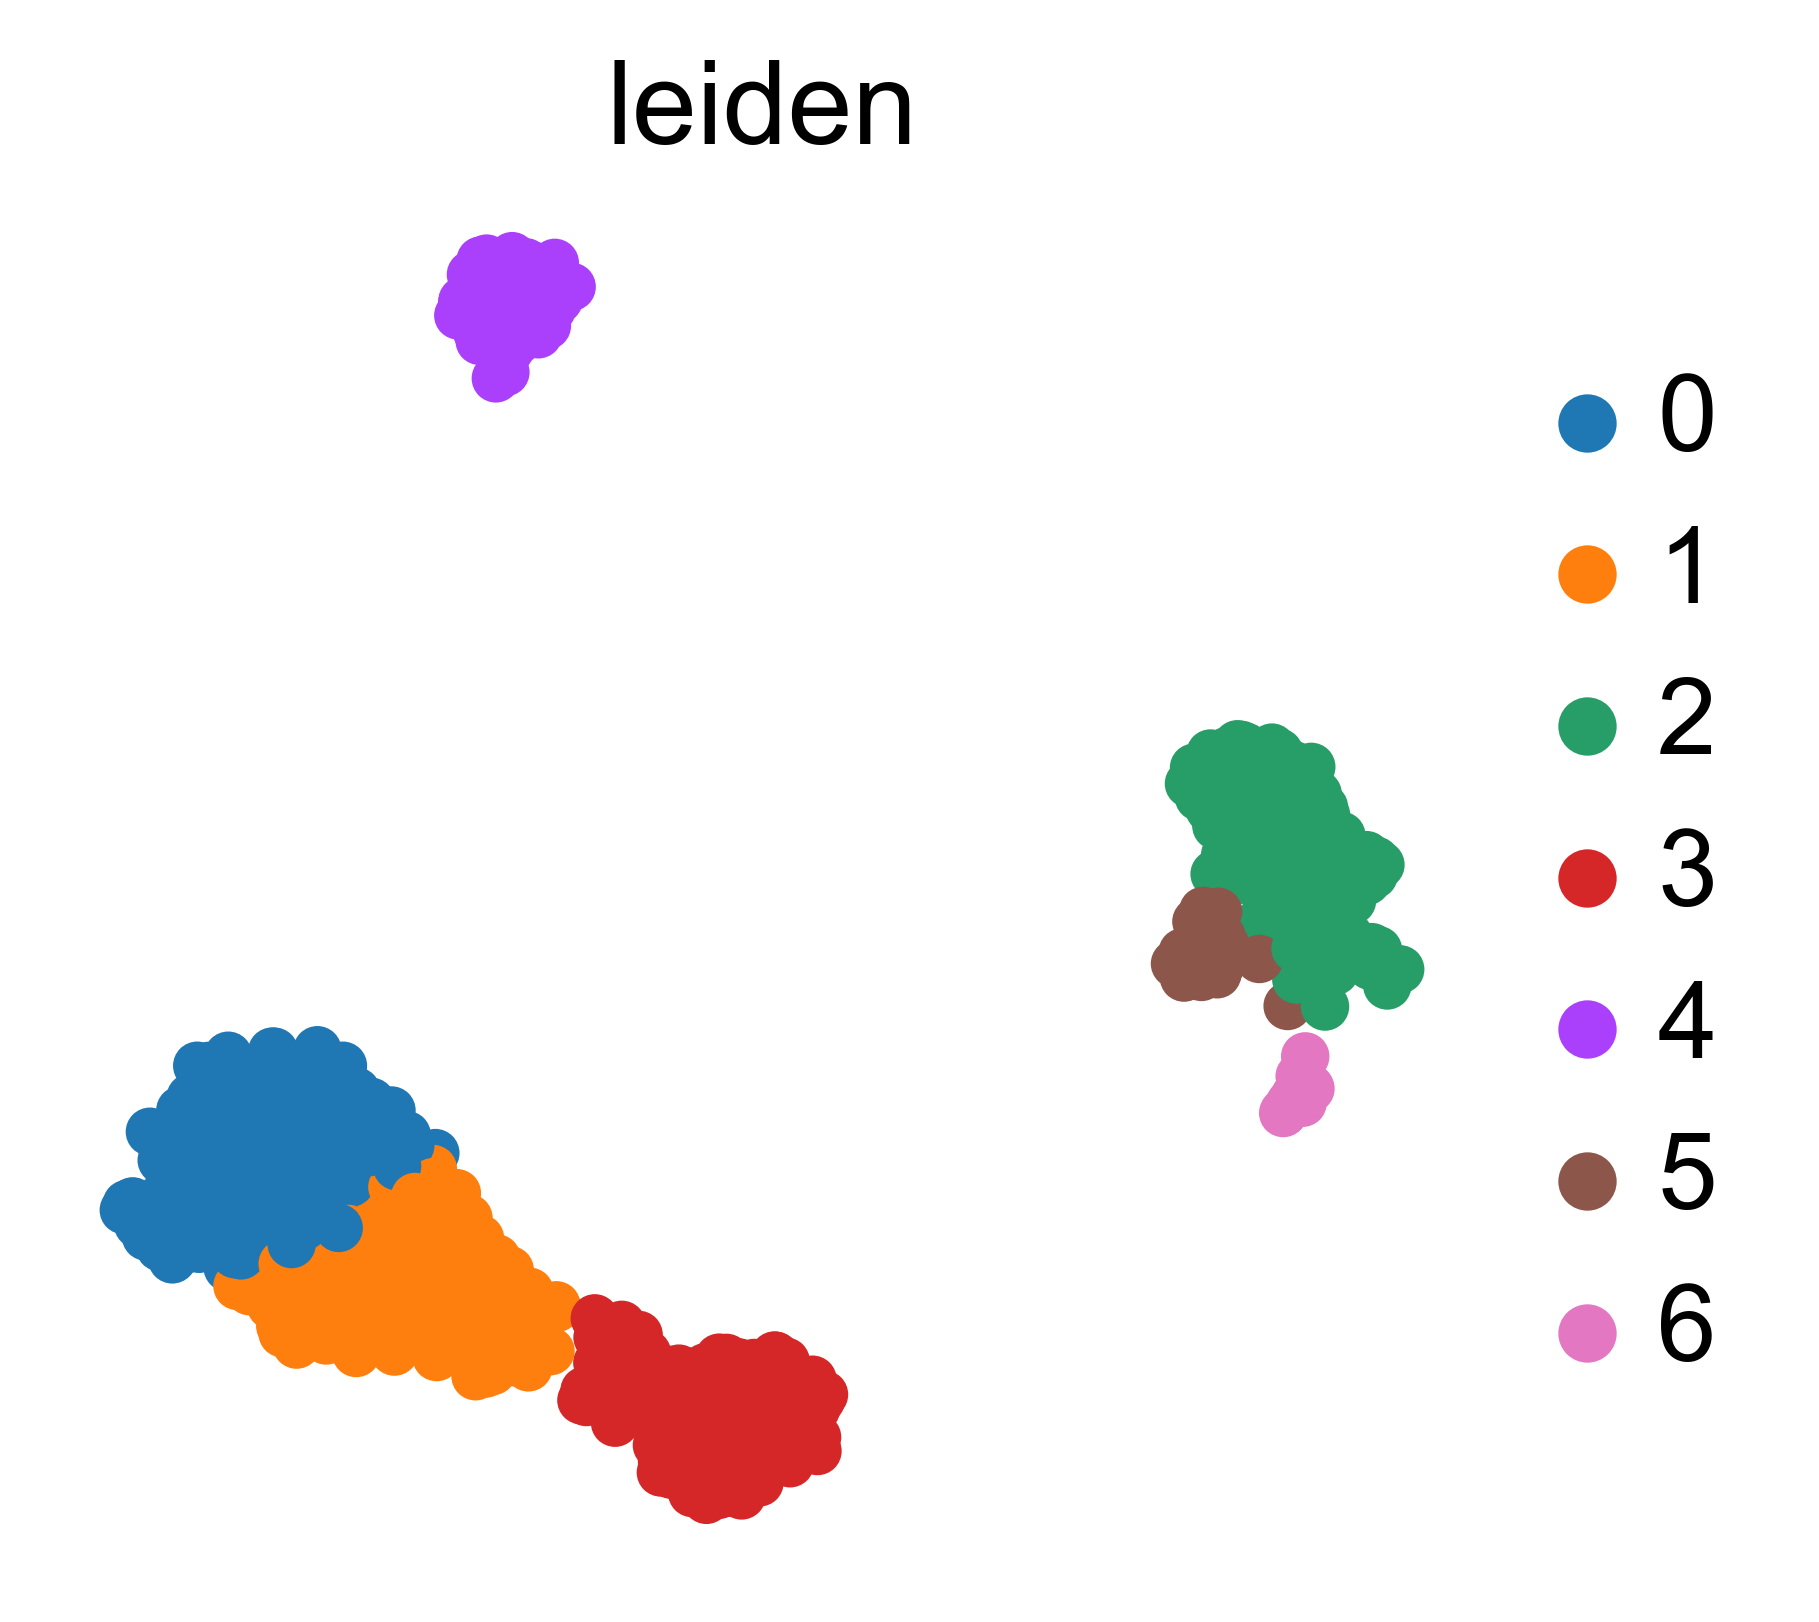

In [13]:
sc.pl.umap(adata, color=["leiden"])

Now that the data is ready, we can then apply the `dt.CELLiD_cluster` function. Specify the `n_predict` parameter to obtain predictions for `n` number of cell types.

In [8]:
# calculate average gene expression of each gene in each cluster
rna_average = pd.DataFrame(adata.X.toarray(), columns=list(adata.var.index))
rna_average["cluster"] = np.array(adata.obs["leiden"])
rna_average = rna_average.groupby("cluster").mean().transpose()
rna_average

cluster,0,1,2,3,4,5,6
MIR1302-2HG,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
FAM138A,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
OR4F5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
AL627309.1,0.004398,0.0,0.000000,0.000000,0.000000,0.0,0.0
AL627309.3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
AC233755.2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
AC233755.1,0.000000,0.0,0.000000,0.000000,0.023412,0.0,0.0
AC240274.1,0.000000,0.0,0.004467,0.008574,0.000000,0.0,0.0
AC213203.1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [9]:
# the result is return as in Pandas DataFrame
cell_type = dt.CELLiD_cluster(rna = rna_average, n_predict = 3)
cell_type

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


INFO:root:Downloading deg dataset...
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   7 | elapsed:    2.2s remaining:    1.7s
[Parallel(n_jobs=10)]: Done   7 out of   7 | elapsed:    2.3s finished


,predicted_cell_type_1,predicted_cell_type_2,predicted_cell_type_3,source_atlas_1,source_atlas_2,source_atlas_3,score_1,score_2,score_3
input_index,,,,,,,,,
0,Naive CD4 T cell,Naive CD4 T cell,Naive CD4 T cell,COVID-19_blood,HNSCC_blood,blood,0.966,0.945,0.930
1,MAIT cell,MAIT cell,Gamma delta T cell,HNSCC_blood,sarcoidosis_blood,bone_marrow,0.803,0.802,0.775
2,CD14 monocyte,CD14 monocyte,Dendritic cell,HNSCC_blood,blood,blood,0.793,0.782,0.706
3,Gamma delta T cell,INF-activated T cell,CD56 NK cell,sarcoidosis_blood,bone_marrow,HNSCC_blood,0.767,0.743,0.680
4,B cell,Naive B cell,Memory B cell,placenta,HNSCC_blood,HNSCC_blood,0.805,0.788,0.724
5,CD16 monocyte,Monocyte,Monocyte,bladder,stomach,gingiva,0.655,0.646,0.636
6,CD16 monocyte,CD16 monocyte,Monocyte,sarcoidosis_blood,bladder,gingiva,0.912,0.677,0.634


From the DISCO website, we have prior knowledge that the downloaded sample is from bone marrow tissue. This information validates the accuracy of our cell type annotation function. Now, we can replace the cluster number with the predicted cell type.

We can extract the relevant information from the cell_type dataframe and convert it into a dictionary. This dictionary will allow us to replace the cluster numbers in our data with their corresponding cell types.

In [10]:
# we extract the information from cell_type dataframe and convert it into a dictionary for replacing the cluster number with cell type
predicted_cell = cell_type["predicted_cell_type_1"].copy()
predicted_cell.index = predicted_cell.index.astype(str)
mapping = predicted_cell.to_dict()
adata.obs["predicted_cell"] = adata.obs["leiden"].replace(mapping)

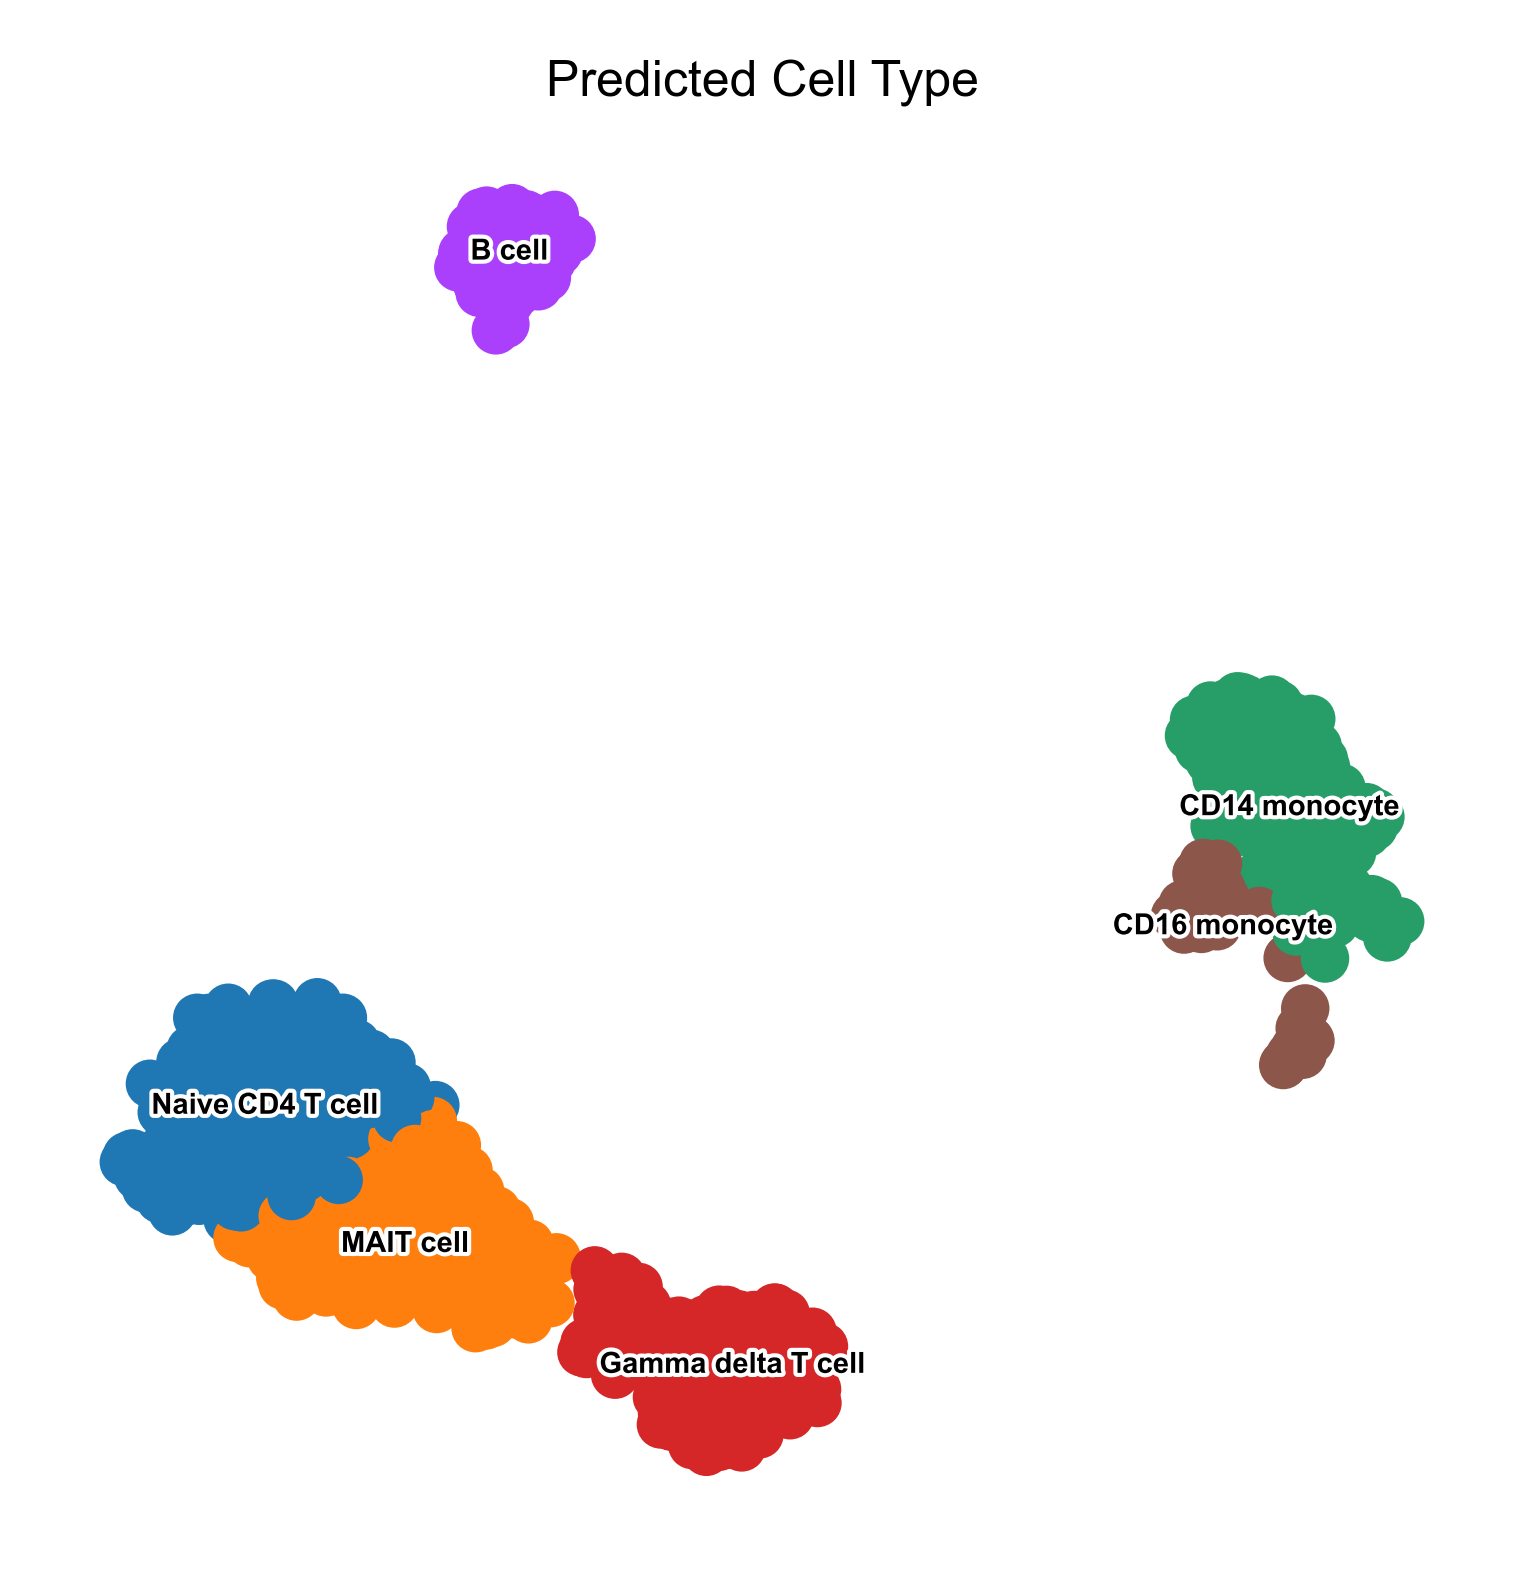

In [14]:
# Generate plot with the legend location on the UMAP
# Generate the UMAP plot
ax = sc.pl.umap(adata, color='predicted_cell', legend_loc='on data',
           frameon=False, legend_fontsize=3.5, legend_fontoutline=1, show=False)

# Set the plot title with the desired font size
ax.set_title('Predicted Cell Type', fontsize=6)

# Show the plot
plt.show()